<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/Dacon_%EC%8B%A0%EC%9A%A9_%EC%98%88%EC%B8%A1_%EB%B3%B5%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/Dacon/대회/신용카드 사용자 연체 예측 AI 경진대회/test.csv')
print(f'train shape:{train.shape}')
print(f'test shape:{test.shape}')
test_index = test['index']

train shape:(26457, 20)
test shape:(10000, 19)


In [ ]:
data = pd.concat([train, test], axis=0)

In [ ]:
data

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,employed,begin_years,working_ratio,daily_wage,property
0,0,0,0,0,0,202500.0,0,1,1,2,13899,4709,1,0,0,0,NaN,2.0,6.0,1.0,38.079452,12.901370,0.500000,33.880135,43.002761,1
1,1,0,0,1,1,247500.0,0,4,0,1,11380,1540,1,0,0,1,Laborers,3.0,5.0,1.0,31.178082,4.219178,0.416667,13.532513,160.714286,2
2,2,1,1,1,0,450000.0,4,1,1,1,19087,4434,1,0,1,0,Managers,2.0,22.0,2.0,52.293151,12.147945,1.833333,23.230471,101.488498,4
3,3,0,0,1,0,202500.0,0,4,1,1,15088,2092,1,0,1,0,Sales staff,2.0,37.0,0.0,41.336986,5.731507,3.083333,13.865323,96.797323,3
4,4,0,1,1,0,157500.0,2,1,1,1,15037,2105,1,0,0,0,Managers,2.0,26.0,2.0,41.197260,5.767123,2.166667,13.998803,74.821853,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,202500.0,4,2,1,1,18593,5434,1,1,1,0,Accountants,2.0,19.0,NaN,50.939726,14.887671,1.583333,29.226053,37.265366,5
9996,36453,1,1,1,0,202500.0,4,4,0,1,10886,1315,1,1,0,0,Laborers,2.0,34.0,NaN,29.824658,3.602740,2.833333,12.079735,153.992395,4
9997,36454,0,0,1,0,292500.0,4,4,1,1,21016,14018,1,0,0,0,Medicine staff,2.0,55.0,NaN,57.578082,38.405479,4.583333,66.701561,20.866029,2
9998,36455,0,1,0,0,180000.0,0,4,1,1,16541,1085,1,0,1,0,NaN,2.0,33.0,NaN,45.317808,2.972603,2.750000,6.559458,165.898618,3


In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
encoders = LabelEncoder()

for i in data.select_dtypes('object'):
  if i == 'occyp_type':
    continue
  else:
    data[i] = encoders.fit_transform(data[i])

In [ ]:
encoders = LabelEncoder()

for i in data.select_dtypes('object'):
  if data[i].nunique() <= 2:
    data[i] = encoders.fit_transform(data[i])
  elif i == 'occyp_type':
    continue
  else:
    data = pd.get_dummies(data=data, columns=[i])

# occyp_type만 남기고 다 인코딩

In [ ]:
corr_matrix = data.corr()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [c for c in upper.columns if any(abs(upper[c])>0.9)]
to_drop
# 제거할 Feature는 안보인다.

[]

In [ ]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

# Feature Engineering

In [ ]:
data['begin_month'] = abs(data['begin_month'])
data['DAYS_EMPLOYED'] = abs(data['DAYS_EMPLOYED'])
data['DAYS_BIRTH'] = abs(data['DAYS_BIRTH'])

In [ ]:
data['age'] = data['DAYS_BIRTH'] / 365
data['employed'] = data['DAYS_EMPLOYED'] / 365

In [ ]:
data['begin_years'] = data['begin_month'] / 12

In [ ]:
data['working_ratio'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH'] * 100
data['daily_wage'] = data['income_total'] / data['DAYS_EMPLOYED']

In [ ]:
data['property'] = data['car'] + data['reality'] + data['phone'] + data['FLAG_MOBIL'] + data['work_phone']

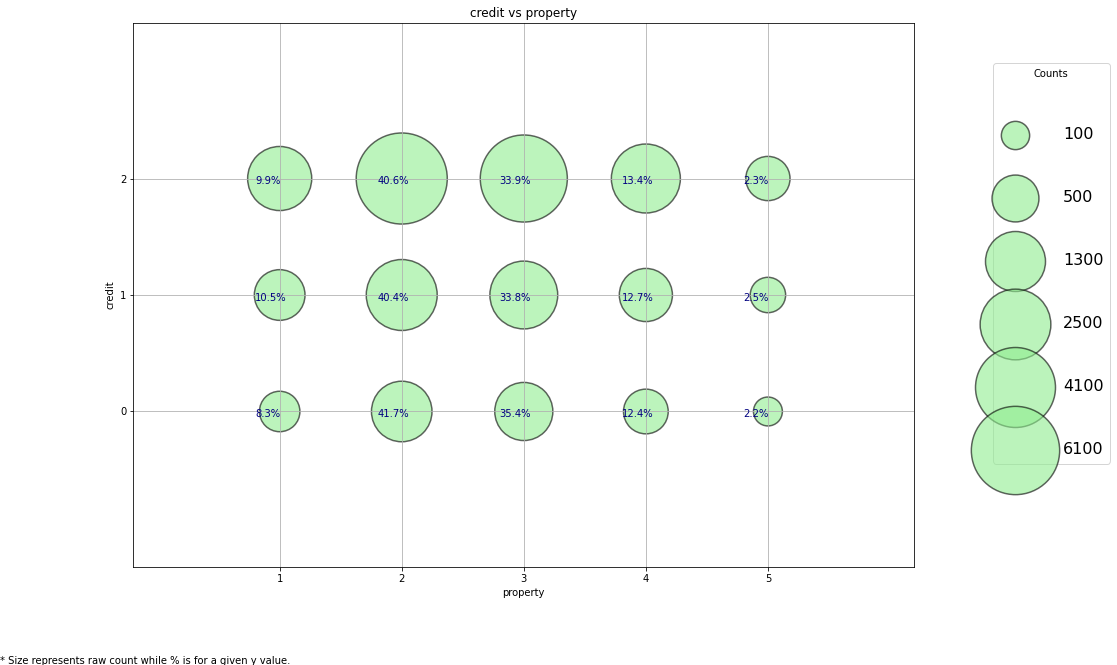

In [ ]:
plot_categoricals('property', 'credit', data)

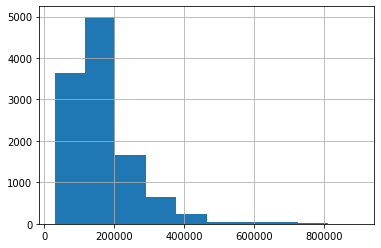

In [ ]:
data[data['occyp_type'].isnull()]['income_total'].hist()
# 어느 특정 직업의 정상적인 분포같음

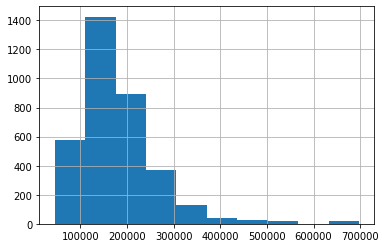

In [ ]:
data[data['occyp_type'] == 'Sales staff']['income_total'].hist()
# Nan값의 연봉에 비하여 분포 차이가 그렇게 많이 나지도 않는다.

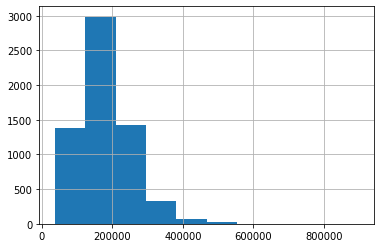

In [ ]:
data[data['occyp_type'] == 'Laborers']['income_total'].hist()

In [ ]:
data['occyp_type'] = data['occyp_type'].fillna('etc')

In [ ]:
data = pd.get_dummies(data=data, columns=['occyp_type'])

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit,age,employed,begin_years,working_ratio,daily_wage,property,occyp_type_Accountants,occyp_type_Cleaning staff,occyp_type_Cooking staff,occyp_type_Core staff,occyp_type_Drivers,occyp_type_HR staff,occyp_type_High skill tech staff,occyp_type_IT staff,occyp_type_Laborers,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_etc
0,0,0,0,0,0,202500.0,0,1,1,2,13899,4709,1,0,0,0,2.0,6.0,1,38.079452,12.901370,0.500000,33.880135,43.002761,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,1,247500.0,0,4,0,1,11380,1540,1,0,0,1,3.0,5.0,1,31.178082,4.219178,0.416667,13.532513,160.714286,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,0,450000.0,4,1,1,1,19087,4434,1,0,1,0,2.0,22.0,2,52.293151,12.147945,1.833333,23.230471,101.488498,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,3,0,0,1,0,202500.0,0,4,1,1,15088,2092,1,0,1,0,2.0,37.0,0,41.336986,5.731507,3.083333,13.865323,96.797323,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,4,0,1,1,0,157500.0,2,1,1,1,15037,2105,1,0,0,0,2.0,26.0,2,41.197260,5.767123,2.166667,13.998803,74.821853,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,0,1,1,0,202500.0,4,2,1,1,18593,5434,1,1,1,0,2.0,19.0,etc,50.939726,14.887671,1.583333,29.226053,37.265366,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9996,36453,1,1,1,0,202500.0,4,4,0,1,10886,1315,1,1,0,0,2.0,34.0,etc,29.824658,3.602740,2.833333,12.079735,153.992395,4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9997,36454,0,0,1,0,292500.0,4,4,1,1,21016,14018,1,0,0,0,2.0,55.0,etc,57.578082,38.405479,4.583333,66.701561,20.866029,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9998,36455,0,1,0,0,180000.0,0,4,1,1,16541,1085,1,0,1,0,2.0,33.0,etc,45.317808,2.972603,2.750000,6.559458,165.898618,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data[data['credit'].isnull()]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,age,employed,begin_years,working_ratio,daily_wage,property


In [ ]:
x_train = data[data['credit'].notnull()]
x_test = data[data['credit'].isnull()]
x_test = x_test.drop(['credit'], axis=1)

print(f'Whole data set shape:{data.shape}')
print(f'train set shape:{x_train.shape}, test set shape:{x_test.shape}')

Whole data set shape:(36457, 26)
train set shape:(36457, 26), test set shape:(0, 25)


In [ ]:
data.select_dtypes('object').nunique()

occyp_type    18
dtype: int64